In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from data_extraction import *
from resp_signal_extraction import *
from rr_extration import *
from sklearn.preprocessing import MinMaxScaler
import re
import tensorflow as tf
import pickle as pkl
from tf_model import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import evidential_deep_learning as edl
import matplotlib.pyplot as plt

2021-08-04 18:55:42.471731: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
with open('output','rb') as f:
    output_data = pkl.load(f)

with open('input','rb') as f:
    input_data = pkl.load(f)

with open('raw_signal.pkl','rb') as f:
    raw_data = pkl.load(f)

input_data = input_data.reshape(input_data.shape[0],input_data.shape[-1],input_data.shape[1])
raw_data = raw_data.reshape(raw_data.shape[0],raw_data.shape[-1],raw_data.shape[1])
annotation = pd.read_pickle('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/annotation.pkl')
reference_rr = (annotation['Reference_RR'].values).reshape(-1,1)

tensor_input = tf.convert_to_tensor(input_data, dtype = 'float32')
tensor_output = tf.convert_to_tensor(output_data, dtype = 'float32')
tensor_ref_rr = tf.convert_to_tensor(reference_rr, dtype = 'float32')
tensor_raw_data = tf.convert_to_tensor(raw_data, dtype = 'float32')
training_ids = annotation['patient_id'] < 13

x_train_data = tensor_input[tf.convert_to_tensor(training_ids.values)]
x_test_data = tensor_input[tf.convert_to_tensor(~(training_ids.values))]
x_train_ref_rr = tensor_ref_rr[tf.convert_to_tensor(training_ids.values)]
x_test_ref_rr = tensor_ref_rr[tf.convert_to_tensor(~(training_ids.values))]
x_train_raw_sig = tensor_raw_data[tf.convert_to_tensor(training_ids.values)]
x_test_raw_sig = tensor_raw_data[tf.convert_to_tensor(~(training_ids.values))]

y_train_data = tensor_output[tf.convert_to_tensor(training_ids.values)]
y_test_data = tensor_output[tf.convert_to_tensor(~(training_ids.values))]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data, x_train_ref_rr))
train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data, x_test_ref_rr))
test_dataset = test_dataset.batch(128)

2021-08-04 18:55:44.819824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-04 18:55:44.888978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-04 18:55:44.889512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2021-08-04 18:55:44.889529: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-04 18:55:44.890920: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-04 18:55:44.890947: I tensorflow/stream_executor/platform/

In [3]:
x_test_raw_sig.shape

TensorShape([814, 2048, 3])

In [5]:
model_input_shape = (128,3)
model  = BRUnet_Multi_resp(model_input_shape)
optimizer = Adam(learning_rate = 1e-4)
loss_fn = Huber()
model(tf.ones((128,128,3)))
model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confd/best_model_lr_0.0001__coeff_0.01.h5')
test_loss_list = []
final_output = tf.convert_to_tensor([])
final_output_rr = tf.convert_to_tensor([])

for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
    output,out_4 = model(x_batch_test)
    test_loss_resp = loss_fn(y_batch_test , output)
    test_loss_rr = loss_fn(x_batch_test_ref_rr , out_4)
    test_loss = test_loss_resp + 0.01*test_loss_rr
    print(tf.shape(output))
    if step == 0:
        final_output = output
        final_output_rr = out_4
    else:
        final_output = tf.concat([final_output , output] , axis = 0)
        final_output_rr = tf.concat([final_output_rr , out_4] , axis = 0)
    test_loss_list.append(test_loss)
    

tf.Tensor([128 128   1], shape=(3,), dtype=int32)
tf.Tensor([128 128   1], shape=(3,), dtype=int32)
tf.Tensor([128 128   1], shape=(3,), dtype=int32)
tf.Tensor([128 128   1], shape=(3,), dtype=int32)
tf.Tensor([128 128   1], shape=(3,), dtype=int32)
tf.Tensor([128 128   1], shape=(3,), dtype=int32)
tf.Tensor([ 46 128   1], shape=(3,), dtype=int32)


In [6]:
final_output

<tf.Tensor: shape=(814, 128, 1), dtype=float32, numpy=
array([[[ 0.5551342 ],
        [ 0.606187  ],
        [ 0.6836978 ],
        ...,
        [ 0.32483757],
        [-0.08327196],
        [-0.02446806]],

       [[ 0.45377386],
        [ 0.58121955],
        [ 0.57823837],
        ...,
        [ 0.15206853],
        [-0.08617862],
        [-0.00402831]],

       [[ 0.34645116],
        [ 0.39489543],
        [ 0.45545077],
        ...,
        [ 0.17130649],
        [ 0.17051461],
        [-0.06203101]],

       ...,

       [[ 0.40365267],
        [ 0.48619425],
        [ 0.49327457],
        ...,
        [ 0.23447037],
        [-0.00168062],
        [-0.01889697]],

       [[ 0.4178133 ],
        [ 0.51786935],
        [ 0.45321488],
        ...,
        [ 0.26269847],
        [ 0.03654757],
        [-0.03281539]],

       [[ 0.4370047 ],
        [ 0.5491718 ],
        [ 0.5428368 ],
        ...,
        [ 0.24993527],
        [ 0.13734892],
        [ 0.05343319]]], dtype=float32)

In [18]:
arr = final_output[59]

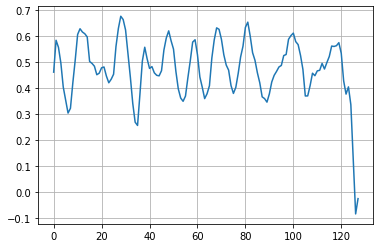

In [19]:
plt.plot(arr)
plt.grid(True)
plt.show()

In [20]:
reference_rr

array([[21.05263158],
       [22.01834862],
       [14.35897436],
       ...,
       [15.70093458],
       [15.41284404],
       [23.52941176]])